# Accelerometer data report (Hand shake)

## Read CSV files

In [1]:
import pandas as pd

## read crystal- and dco- timestamped data
columns = ['Timestamp', 'X', 'Y', 'Z'];
crystal_df = pd.read_csv('Data/Crystal_accel_COM9_4MHz_2.csv', names=columns);
crystal = crystal_df.as_matrix();

dco_df = pd.read_csv('Data/DCO_accel_COM6_2MHz_2.csv', names=columns);
dco = dco_df.as_matrix();


## Compensate different sizes (due to clock speeds)

In [2]:
# crystal file likely to be longer than DCO file, due to different clock frequencies
# (Crystal: 4MHz, DCO: 2MHz)
diff = abs(len(crystal) - len(dco));

if(len(crystal) > len(dco)):
    #crystal = crystal[diff:-1];
    crystal = crystal[0:-diff];
else:
    #dco = dco[diff:-1];
    dco = dco[0:-diff];

## Compute magnitude of accelerometers

In [3]:
import numpy as np

crystal_mag = np.square(crystal[:,1]) + np.square(crystal[:,2]) + np.square(crystal[:,3]);
crystal_mag = np.sqrt(crystal_mag);

dco_mag = np.square(dco[:,1]) + np.square(dco[:,2]) + np.square(dco[:,3]);
dco_mag = np.sqrt(dco_mag);

# Compute elapsed times
ctime = crystal[:,0];
ctime = ctime - ctime[0];

dtime = dco[:,0];
dtime = dtime - dtime[0];

## Plot the magnitudes together

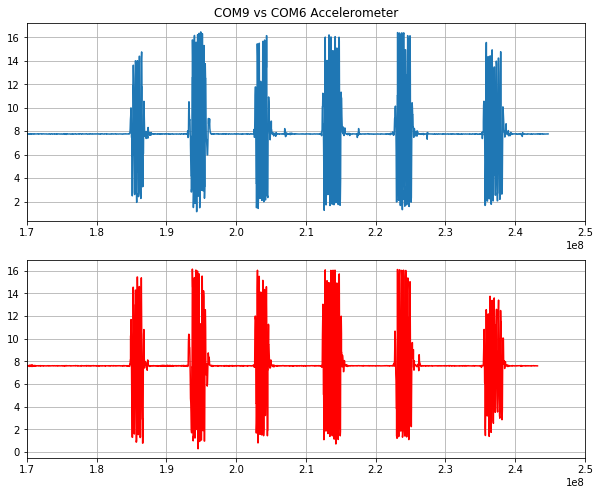

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();

linepos = 19000000

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Plot both accelerometers
f, axes = plt.subplots(2);
        
ax1 = axes[0];
ax2 = axes[1];

#plt.style.use('classic')

ax1.plot(ctime, crystal_mag);
ax1.grid();
ax1.set_xlim([170000000, 250000000]);
#ax1.vlines([linepos], 0, 15, colors='k');
ax1.set_title('COM9 vs COM6 Accelerometer');

ax2.plot(dtime, dco_mag,color='r');
ax2.set_xlim([170000000, 250000000]);
#ax2.vlines([linepos], 0, 15, colors='k');
ax2.grid();

plt.show();

## Train Classifier for Handshake recognition. 

In [5]:
!python3 -m pip install numpy

In [4]:
# Perform some classification to find the area with the handshaking activity
# Once area has been located on both COM9 and COM6, it becomes possible to compute offset and skew
# This is just a demo, with a classifier constructed from the reference node (crystal) and
# applied to the synchronizing node (DCO). 

import AccelerometerFeatures as af
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Create feature extraction object
ae = af.AccelerometerFeatures();
    
# Time is in microseconds, should convert to milliseconds
window_size = 70;     # in millis, with 100Hz each window should have ~9-10 samples
window_overlap = 10;

# extract crystal accelerometer features
X, y, w = ae.extract_features_from_files("crystal", window_size, window_overlap);

C = 1.0;  # SVM regularization parameter

# Fit SVC onto crystal data
svc = svm.SVC(kernel='poly', C=C);
svc.fit(X, y)

# To predict, use the following lines. (These are used in the next step anyway)
X2, y2, w2 = ae.extract_features(dco, window_size, window_overlap);
#X3, y3, w3 = ae.extract_features(crystal, window_size, window_overlap);

# Compute cross validation accuracy score
cross_val_score(svc, X2, y2, scoring='accuracy')
#cross_val_score(svc, X3, y3, scoring='accuracy')

ValueError: all the input arrays must have same number of dimensions

## Reconstruct Events Onset/Offset 

In [ ]:
# Process to reconstruct the signal and detect the areas with 
# handshake activity in it.
import EventAnalyzer as ea

# Instantiate event analyzer
analyzer = ea.EventAnalyzer();

# Plot both accelerometers events for display purposes
f, axes = plt.subplots(2);

#f.text(5, 8, "Magnitude", va='center', rotation='vertical')

ax1 = axes[0];
ax2 = axes[1];

crystal_events = analyzer.find_events(crystal, window_size, window_overlap, svc, ax1);
ax1.set_title('Crystal vs DCO');
ax1.grid();
ax1.set_xlim([170000, 250000]);
#ax1.legend(handles=[e,ne], loc="upper left")

dco_events = analyzer.find_events(dco, window_size, window_overlap, svc, ax2);
ax2.set_xlim([170000, 250000]);
ax2.grid();
#ax2.legend(handles=[e,ne], loc="upper left")
plt.show()

# Retrieve all events
all_crystal_events = analyzer.retrieve_all_events("crystal", window_size, window_overlap, svc);
all_dco_events = analyzer.retrieve_all_events("dco", window_size, window_overlap, svc);

## Compute X-Correlation between COM9 and COM6 accelerometers

In [ ]:
import scipy as sp
from scipy.signal import correlate

# delta time array to match xcorr
nsamples = len(crystal_mag);
# Sampling rate
SRATE = 100;
# regularize datasets by subtracting mean and dividing by s.d.
crystal_mag -= crystal_mag.mean();
crystal_mag /= crystal_mag.std();

dco_mag -= dco_mag.mean();
dco_mag /= dco_mag.std();

# Find X-Correlation
xcorr = correlate(crystal_mag, dco_mag);

# delta time array to match xcorr
dt = np.arange(1-nsamples, nsamples);
recovered_sample_shift = dt[xcorr.argmax()];
offset = recovered_sample_shift * SRATE;

print ("Recovered offset: ", recovered_sample_shift, " samples, or " , offset, " microseconds for 100Hz sample rate");

## Compute event onsets 

The Least Squares Estimator (LSE) $\hat{\beta}$ is that value of $b$ that minimizes

\begin{equation*}
\sum^{n}_{i=1} (y_i - f_b(x_i))^2
\end{equation*}

We will now cycle through the events we have found in Section 1.6 and mark all the event onsets for the DCO (node $j$, to be synchronized) and the crystal (node $i$, reference node).

In [ ]:
# Cycle through events found in Section 1.6 and find all event onsets for DCO and Crystal.
import scipy.optimize as optimization
from sklearn import linear_model

# Chose a model that will create bimodality.
def func(x, a, b):
    return a + b*b*x  # Term b*b will create bimodality.

crystal_start_times = [];
for c in all_crystal_events:
    crystal_start_times.append([crystal[c[0]][0]]);

dco_start_times = [];
for d in all_dco_events:
    dco_start_times.append(dco[d[0]][0] - offset)
    
# Split into training and test data
X = crystal_start_times
Y = dco_start_times

# Need MORE test sets
length = 5;

x_train = X[:length];
x_test = X[length:];


y_train = Y[:length];
y_test = Y[length:];


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train);

skew = regr.coef_;

# The mean squared error
#print("Mean squared error: %.2f microseconds"
#      % np.mean((regr.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test) , '\n where 1.00 indicates perfect prediction')

# Plot outputs

plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=2)

# Some past points from older datasets
x_test = np.append(x_test, [[1487352639090529.0], [1487352600090529.0], [1487352680090529.0]]);
y_test = np.append(y_test,  [1487352650090529.0, 1487352600090529.0, 1487352680090529.0]);

plt.scatter(x_test, y_test,  color='black')

frame = plt.gca()

plt.grid(True);

frame.xaxis.set_major_formatter(plt.NullFormatter())
frame.yaxis.set_major_formatter(plt.NullFormatter())

plt.xlabel("Node i event start time")
plt.ylabel("Node j event start time")

print ("Offset detected: ", abs(offset), " microseconds")
print ("Skew detected: ", skew[0])

plt.show()

## Plot Drift Improvement Results

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")

cctime = ctime[:len(ctime) - 330];
ddtime = dtime[:len(dtime) - 330];
samples = np.linspace(0, len(cctime), num=len(cctime))

# Plot drift 
drift = abs(cctime - ddtime);

# Apply the estimated skew and offset
cctime = (cctime * skew) + offset;

adjusted_drift = abs(cctime - ddtime);

ax1 = axes[0];
ax2 = axes[1];

xp = np.linspace(0, len(adjusted_drift), 100);

deg = 5;
z1 = np.poly1d(np.polyfit(samples, drift, deg))
z2 = np.poly1d(np.polyfit(samples, adjusted_drift, deg));

plt.plot(xp, z1(xp), 'r-', label="Raw Drift");
plt.plot(xp, z2(xp), 'b-', label="Our Method");

#f, axes = plt.subplots(2);
#ax1.plot(xp, z1(xp), 'r-', label="Raw Drift");
#ax1.plot(xp, z2(xp), 'b-', label="Our Method");

#ax2.plot(drift, 'r', label="Raw Drift");
#ax2.plot(adjusted_drift, 'b', label="Our Method");

plt.legend(loc="upper left")
plt.xlim([0,7500]);
plt.ylim([0,3000000]);
plt.xlabel("Samples")
plt.ylabel("Time (us)")
plt.show()

# Plot average improvement over no-drift
avg_drift = sum(drift) / len(drift);
adjusted_drift_avg = sum(adjusted_drift) / len(adjusted_drift);
decrease = avg_drift - adjusted_drift_avg;
print("Drift reduced by %.2f%%" % ((decrease / avg_drift) * 100))